### 1. Reading in the images

Start by getting 10 random images from one fake dataset and the real dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Downgrade OpenCV to enable some patented algorithms.

In [2]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 104kB/s 
     |████████████████████████████████| 20.2MB 12.3MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
import copy
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import random

In [4]:
!ls '/content/drive/My Drive/FakeImageDetector'

 all_ex_nonex.pickle
 all_face_path.pickle
 analitycs
 data
 Data_illustrations.ipynb
 dataset
 dataset_drive
 deeepfakedownload.ipynb
 Deepfakes_to_images.sh
 download_data.ipynb
 Extract_DeepFakeDetection_faces.ipynb
 face_detector.py
 faceforensics_download_v4.py
 feature_extraction
 FeaturesToVectors.ipynb
 ForPresentation.ipynb
 haarcascade_frontalface_default.xml
 KNN
 lgbm
 LogisticRegression
' ML Presentation_local.pptx'
' ML Presentation.pptx'
 Neural_generated_content_detection_materials.gdoc
 Presentation_draft.gslides
 real_images
 remove_jpeg.sh
'test7_withfaces (1).gsheet'
 test7_withfaces.csv
 test7_withfaces.gsheet
 test_images
 test_video
 Untitled0.ipynb
 video_to_images.py
 video_to_images.sh
 video_to_real_images.py


In [11]:
!ls '/content/drive/My Drive/FakeImageDetector/data/manipulated_sequences/Face2Face/c23'

faces  images  images.tar  videos


In [0]:
def show_images(images, title=None):
  plt.rcParams['figure.figsize'] = (20.0, 16.0)

  for i in range(0, len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis('off')

  if title is not None:
    plt.suptitle(title, y = 0.61, fontsize = 20, fontweight = 'bold')
  
  plt.show()

def get_n_images(base_dir, n):
  images = []

  random.seed(0)
  filenames = random.sample(os.listdir(base_dir), n)
  for filename in filenames:
    print(filename)
    image = cv2.imread(base_dir + '/' + filename)[...,::-1]
    resized = cv2.resize(image, (129, 129), interpolation = cv2.INTER_AREA)
    images.append(resized)

  return images

In [25]:
face2face_images = get_n_images('/content/drive/My Drive/FakeImageDetector/data/manipulated_sequences/Face2Face/c23/faces', 5)

479_706.mp4_6.jpg_fd_1.jpg
360_437.mp4_7.jpg_fd_1.jpg
655_444.mp4_5.jpg_fd_1.jpg
035_036.mp4_5.jpg_fd_1.jpg
331_260.mp4_5.jpg_fd_1.jpg


### 2. Harris corner detection

In [0]:
def harris_corner_detection(images):
  corner_images = copy.deepcopy(images)
  dsts = []
  res_images = []
  for image in corner_images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    dsts.append(dst)
    res_image = image.copy()
    res_image[dst > 0.01 * dst.max()] = [255, 0, 0]
    res_images.append(res_image)
  return res_images

In [0]:
corner_images = harris_corner_detection(face2face_images)
show_images(corner_images)

### 3. SIFT

In [0]:
def sift(images):
  sift_images = copy.deepcopy(images)
  res_images = []
  for image in sift_images:
    image = np.ascontiguousarray(image, dtype=np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints = sift.detect(gray, None)
    res_image = cv2.drawKeypoints(image, keypoints, image)
    res_images.append(res_image)
  return res_images

In [0]:
sift_images = sift(face2face_images)
show_images(sift_images)

### 4. SURF

In [0]:
def surf(images):
  surf_images = copy.deepcopy(images)
  res_images = []
  for image in surf_images:
    image = np.ascontiguousarray(image, dtype=np.uint8)
    surf = cv2.xfeatures2d.SURF_create(400)
    keypoints, des = surf.detectAndCompute(image, None)
    res_image = cv2.drawKeypoints(image, keypoints, image)
    res_images.append(res_image)
  return res_images

In [0]:
surf_images = surf(face2face_images)
show_images(surf_images)

### 5. FAST

In [0]:
from collections import defaultdict

def fast(images):
  fast_images = copy.deepcopy(images)
  res_images = []
  cropped_images = defaultdict(list)
  i = 0
  for image in fast_images:
    image = np.ascontiguousarray(image, dtype=np.uint8)
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(image, None)
    for kp in keypoints:
      y_low = int(max(0, (kp.pt[1] - np.ceil(kp.size / 2)).item()))
      y_high = int(min(image.shape[1] - 1, (kp.pt[1] + np.ceil(kp.size/2)).item()))
      x_low = int(max(0, (kp.pt[0] - np.ceil(kp.size/2)).item()))
      x_high = int(min(image.shape[0] - 1, (kp.pt[0] + np.ceil(kp.size/2)).item()))
      cropped = image[y_low:y_high, x_low:x_high]
      plt.rcParams['figure.figsize'] = (3.0, 3.0)
      plt.imshow(cropped)
      plt.show()
      cropped_images[i].append(cropped)
    res_image = cv2.drawKeypoints(image, keypoints, image)
    res_images.append(res_image)
    i += 1
  return res_images, cropped_images

In [0]:
fast_images, cropped_images = fast(face2face_images[0:1])
show_images(fast_images)

### 6. ORB

In [0]:
def orb(images):
  orb_images = copy.deepcopy(images)
  res_images = []
  for image in orb_images:
    image = np.ascontiguousarray(image, dtype=np.uint8)
    orb = cv2.ORB_create()
    keypoints = orb.detect(image, None)
    keypoints, des = orb.compute(image, keypoints)
    res_image = cv2.drawKeypoints(image, keypoints, image)
    res_images.append(res_image)
  return res_images

In [0]:
orb_images = orb(face2face_images)
show_images(orb_images)

### 7. Putting it all together

In [0]:
show_images(corner_images, 'Harris corner detection')
show_images(sift_images, 'SIFT (Scale-Invariant Feature Transform)')
show_images(surf_images, 'SURF (Speeded-Up Robust Features)')
show_images(fast_images, 'FAST')
show_images(orb_images, 'ORB (Oriented FAST and Rotated BRIEF)')

## Feature extraction with face_recognition

In [8]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 119kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=34ba2366937b19d3e204716bec65f6dc7474a599e0021da44219a53ed4740217
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
import face_recognition

bb_dimensions = (40, 40)

def get_bounding_box(data):
    min_x = min(data, key = lambda t: t[0])[0]
    max_x = max(data, key = lambda t: t[0])[0]
    min_y = min(data, key = lambda t: t[1])[1]
    max_y = max(data, key = lambda t: t[1])[1]

    offset_x = int((bb_dimensions[0] - (max_x - min_x)) / 2.0)
    offset_y = int((bb_dimensions[1] - (max_y - min_y)) / 2.0)

    bb_tl = (min_x - offset_x, min_y - offset_y)
    bb_bl = (min_x - offset_x, max_y + offset_y)
    bb_tr = (max_x + offset_x, min_y - offset_y)
    bb_br = (max_x + offset_x, max_y + offset_y)

    return [bb_tl, bb_tr, bb_br, bb_bl]

def get_pixels(I, bb):
    top_left = bb[0]
    pixels = np.zeros((bb_dimensions[0], bb_dimensions[1], 3), dtype=np.uint8)
    for i in range(bb_dimensions[0]):
        for j in range(bb_dimensions[1]):
            pixels[j, i, :] = I[top_left[1] + j, top_left[0] + i, :]
    return pixels

# image: numpy ndarray (e.g. from cv2.imread)
def get_feature_vector(image):
  face_landmarks = face_recognition.face_landmarks(image)[0]
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  eyel = get_pixels(image, get_bounding_box(face_landmarks['left_eye']))
  plt.imshow(eyel)
  plt.axis('off')
  plt.show()
  eyer = get_pixels(image, get_bounding_box(face_landmarks['right_eye']))
  plt.imshow(eyer)
  plt.axis('off')
  plt.show()
  nose = get_pixels(image, get_bounding_box(face_landmarks['nose_bridge'] + face_landmarks['nose_tip']))
  plt.imshow(nose)
  plt.axis('off')
  plt.show()
  lips = get_pixels(image, get_bounding_box(face_landmarks['top_lip'] + face_landmarks['bottom_lip']))
  plt.imshow(lips)
  plt.axis('off')
  plt.show()
  feature_vector = np.concatenate((eyel.ravel(), eyer.ravel(), nose.ravel(), lips.ravel()))
  return feature_vector

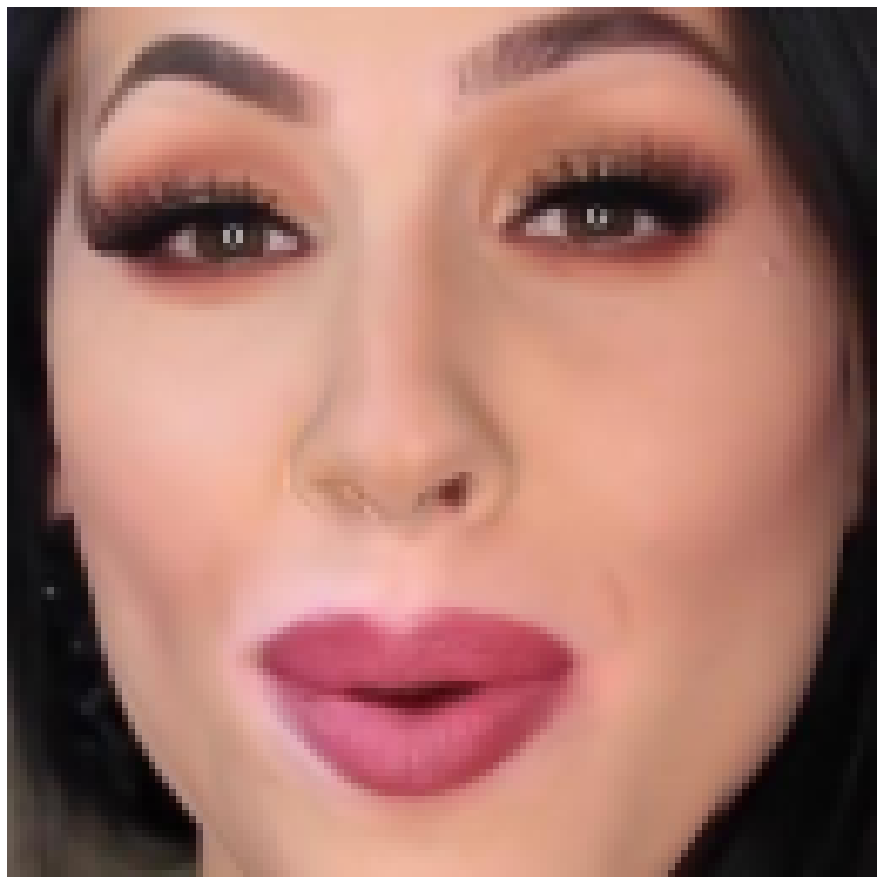

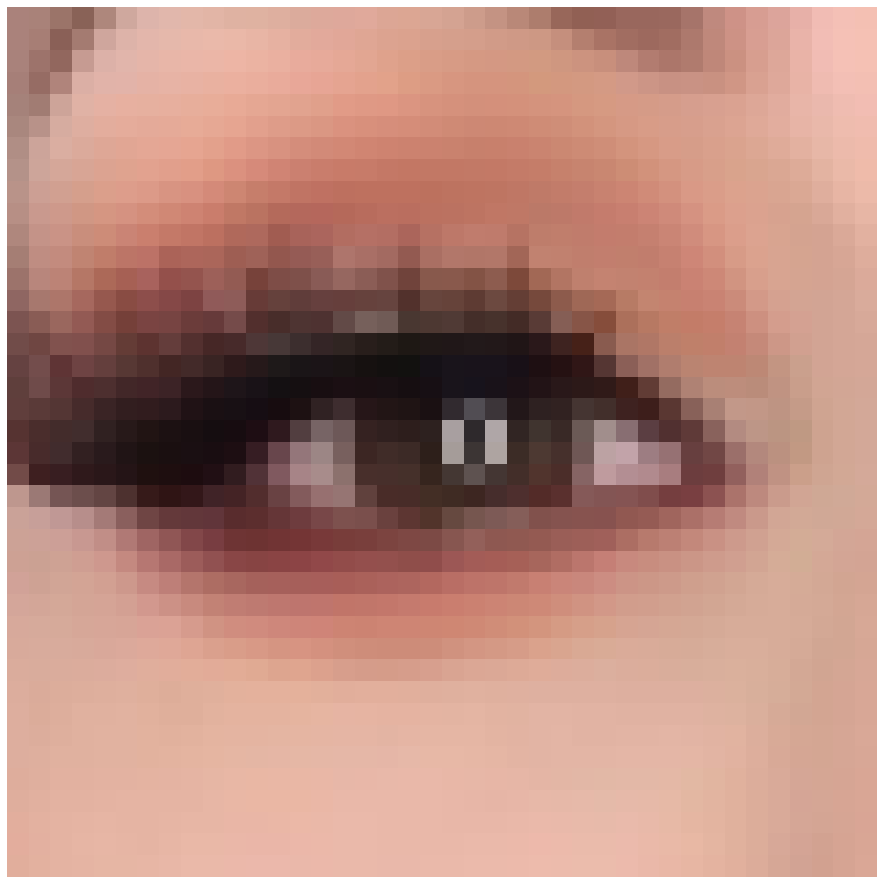

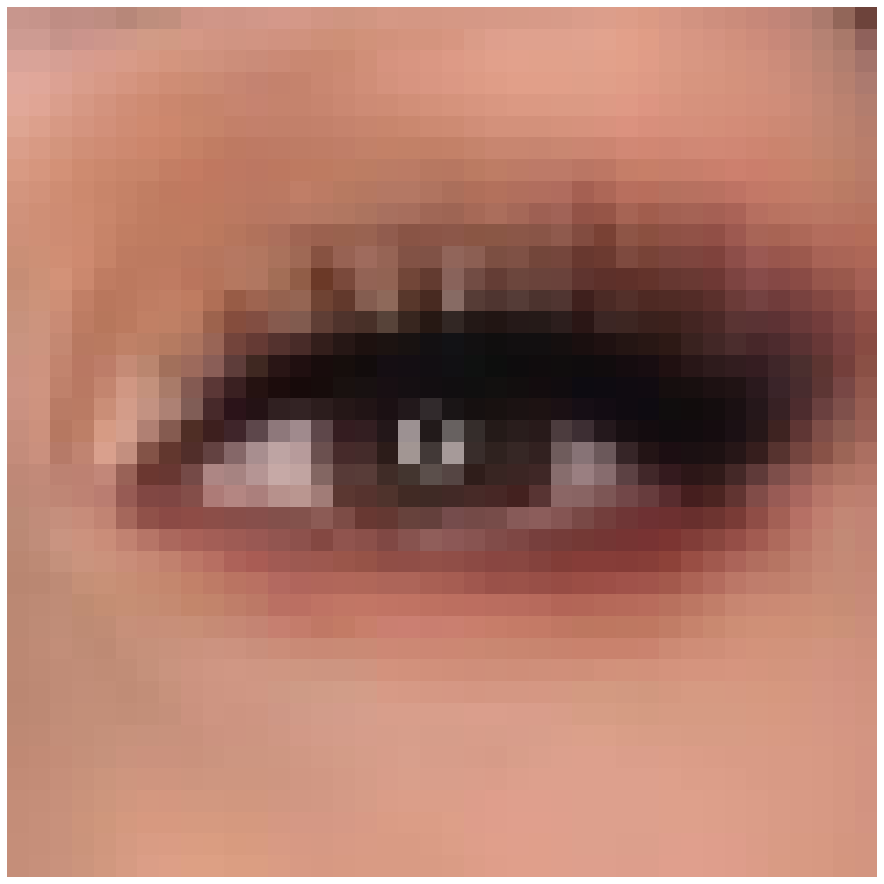

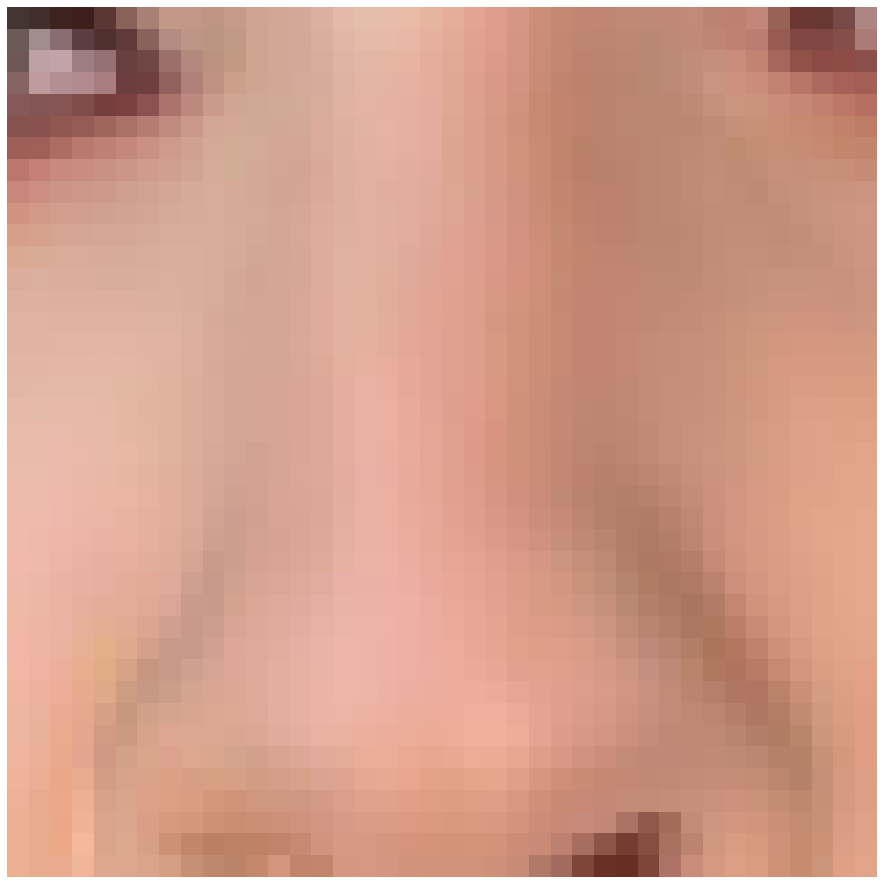

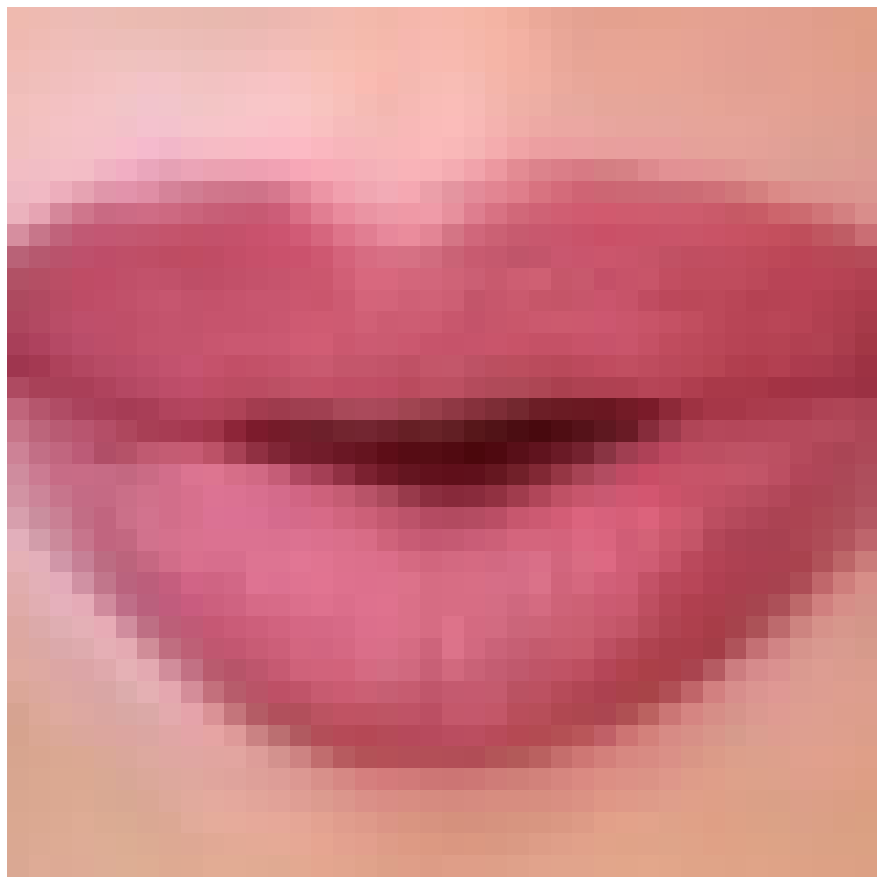

(19200,)


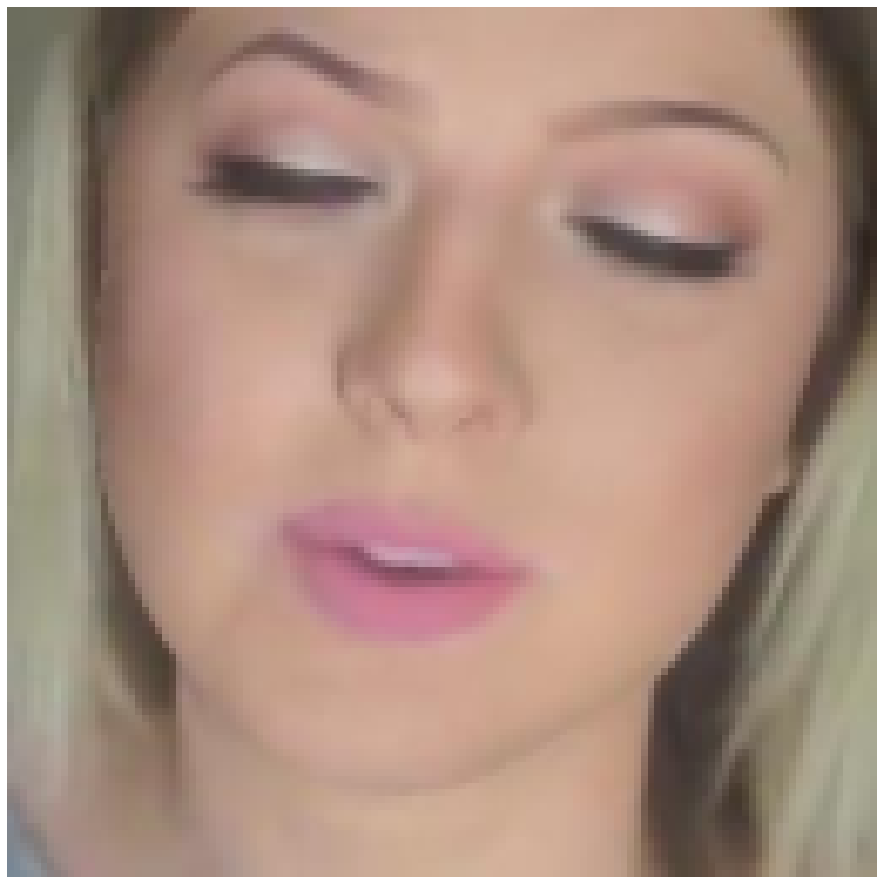

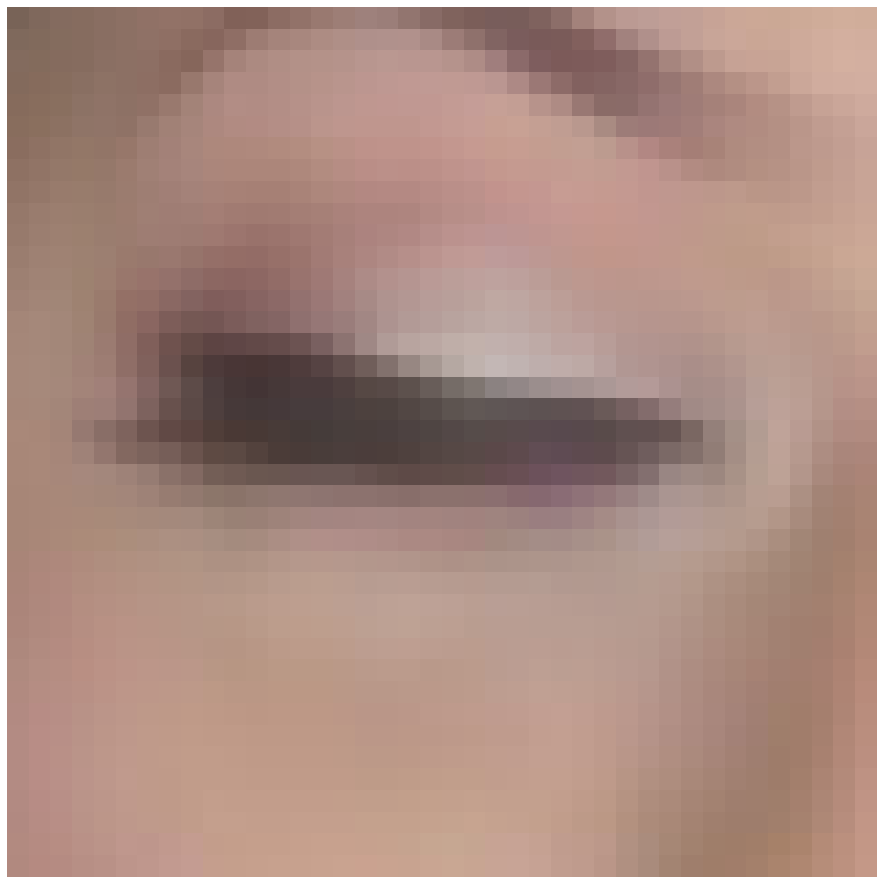

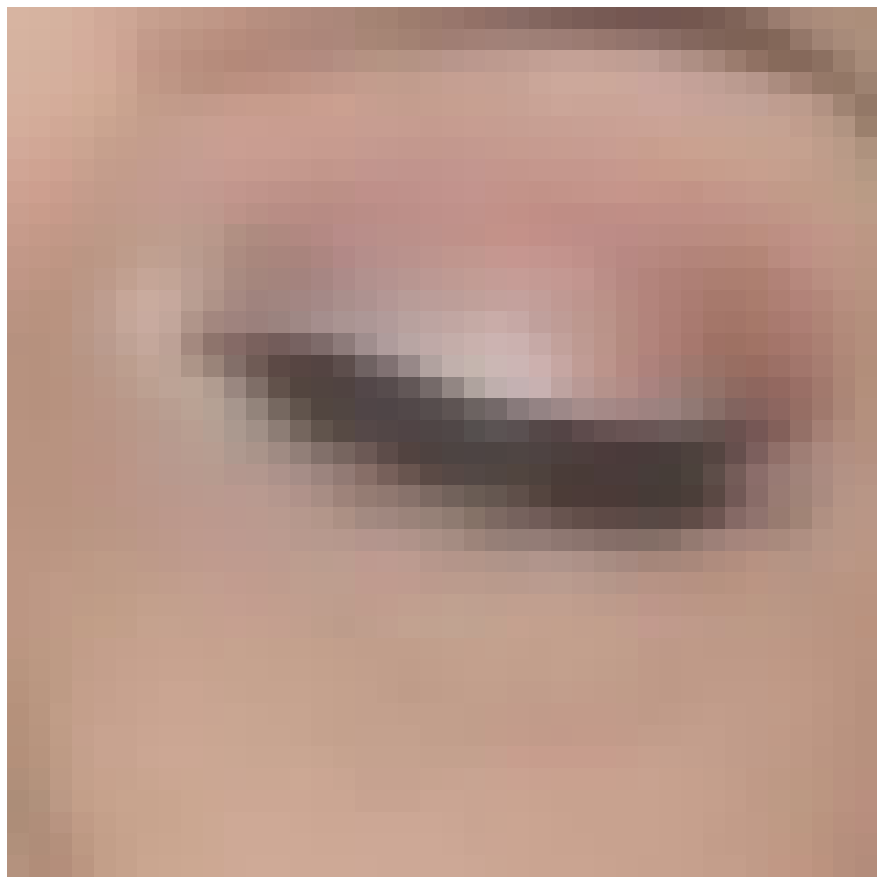

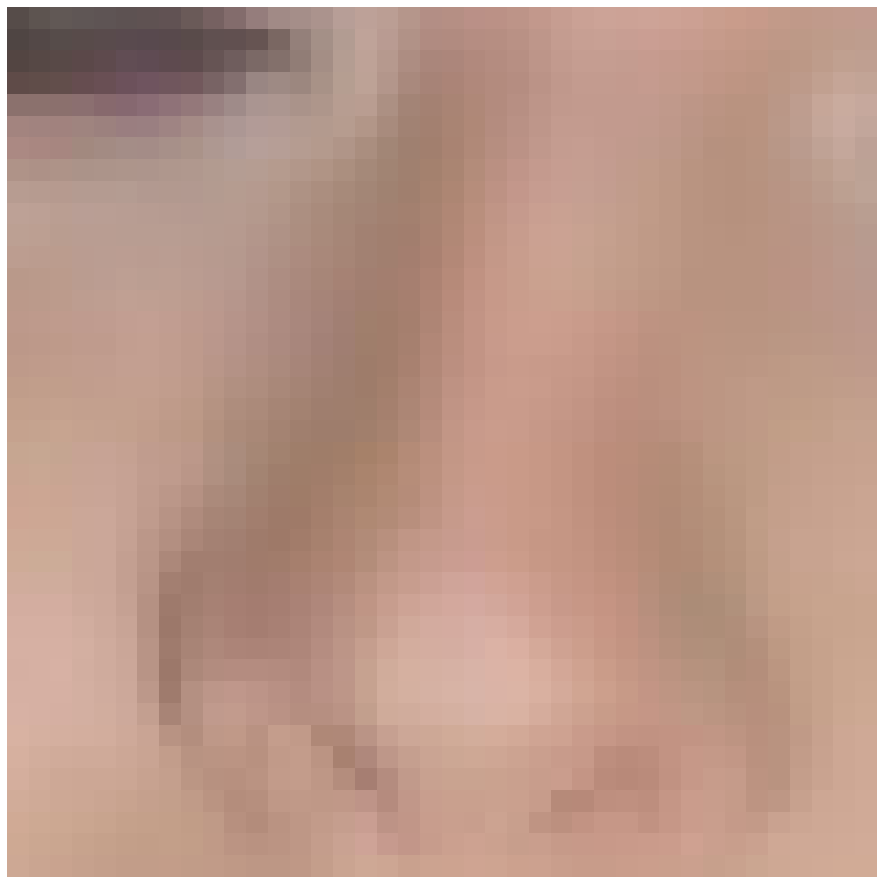

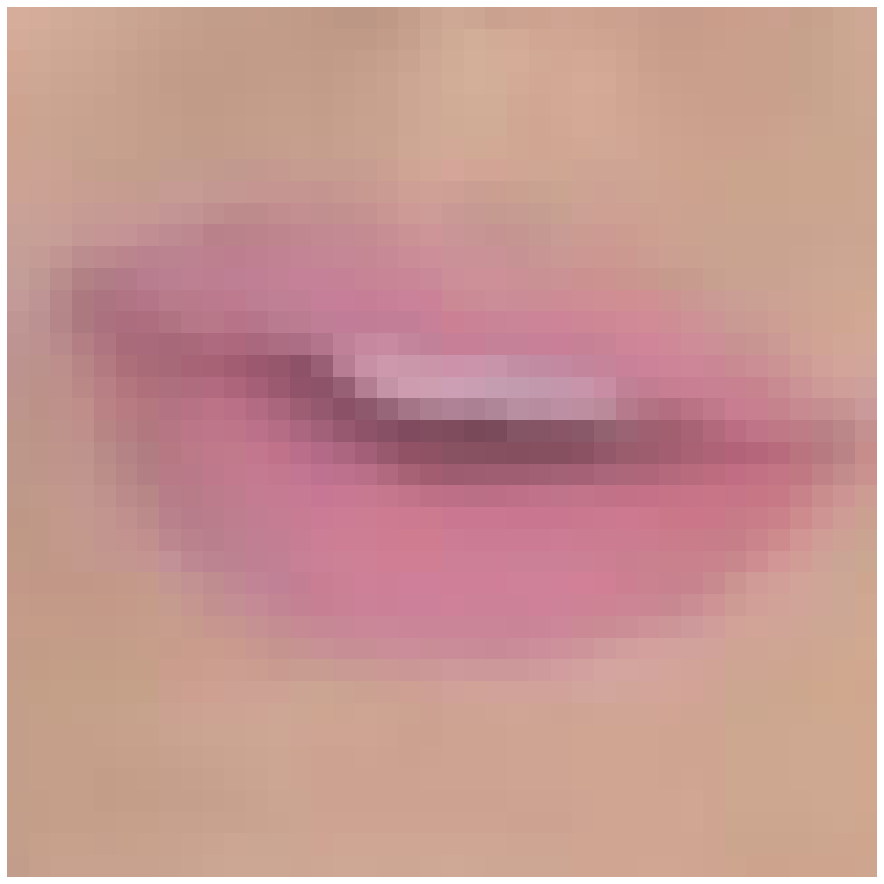

(19200,)


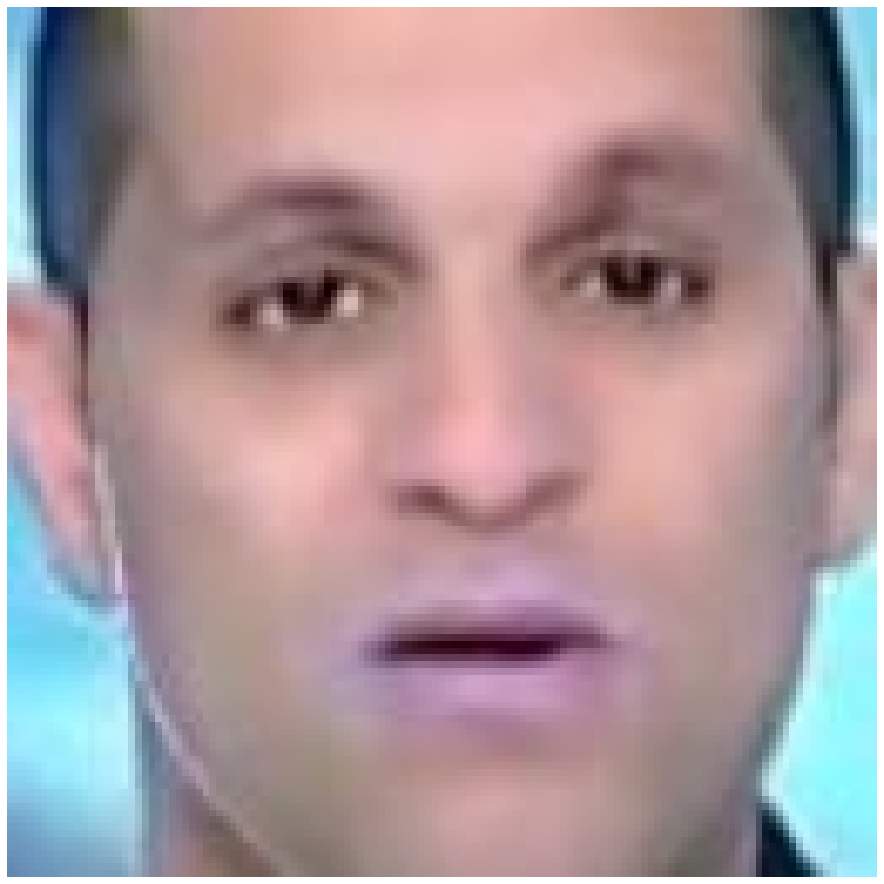

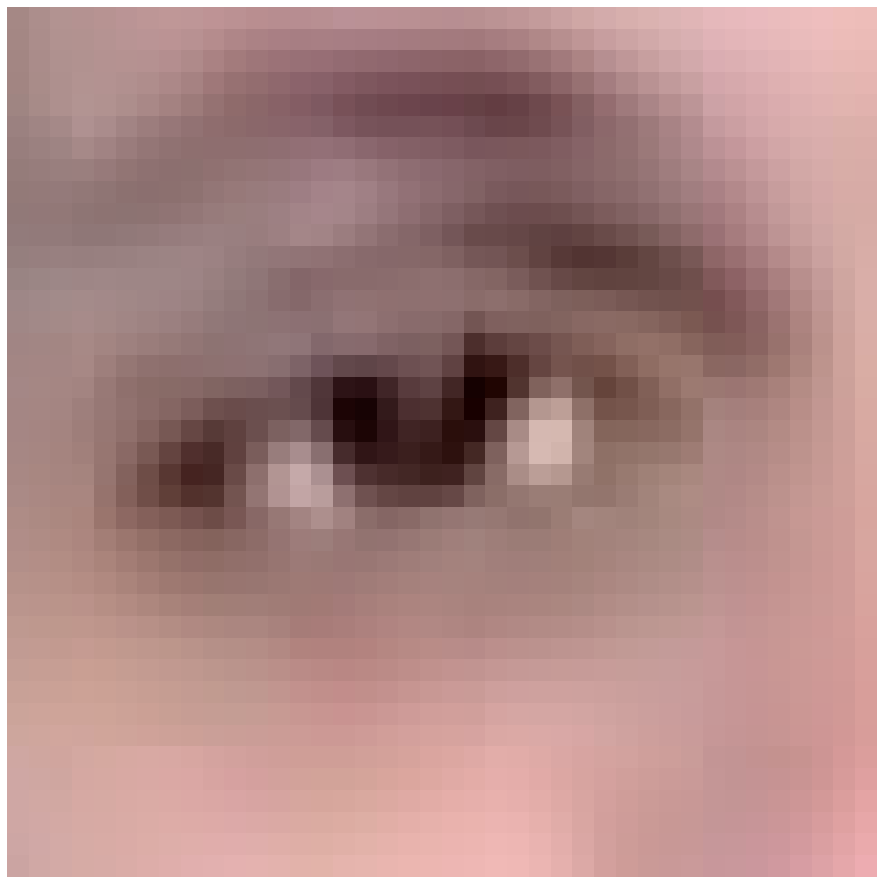

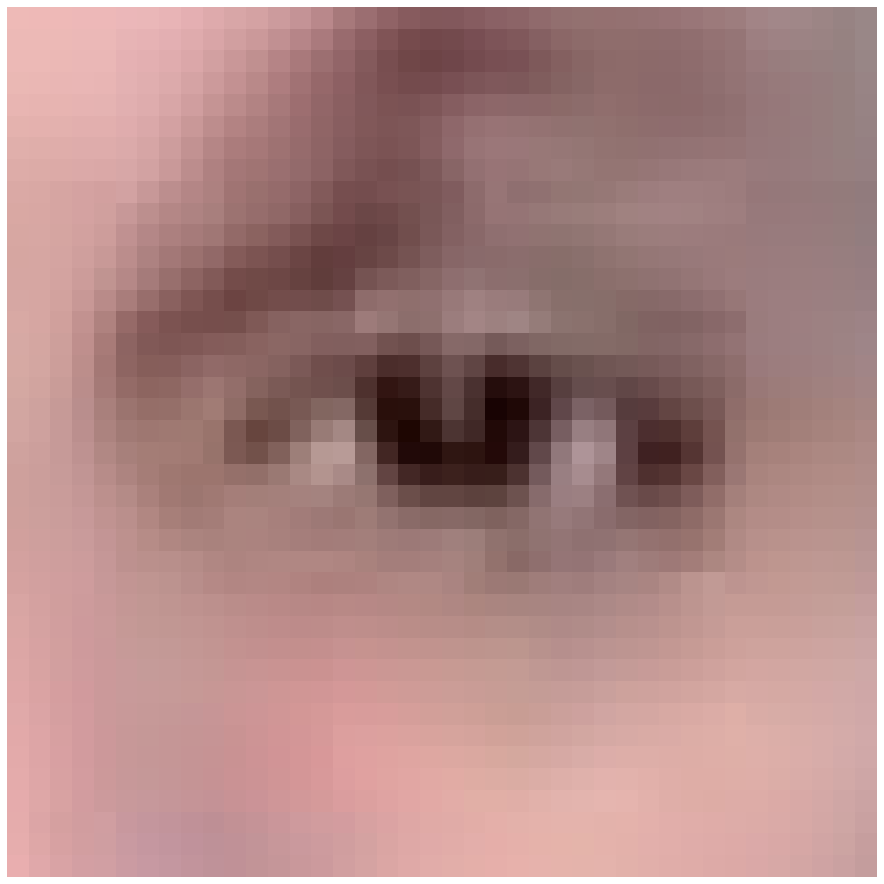

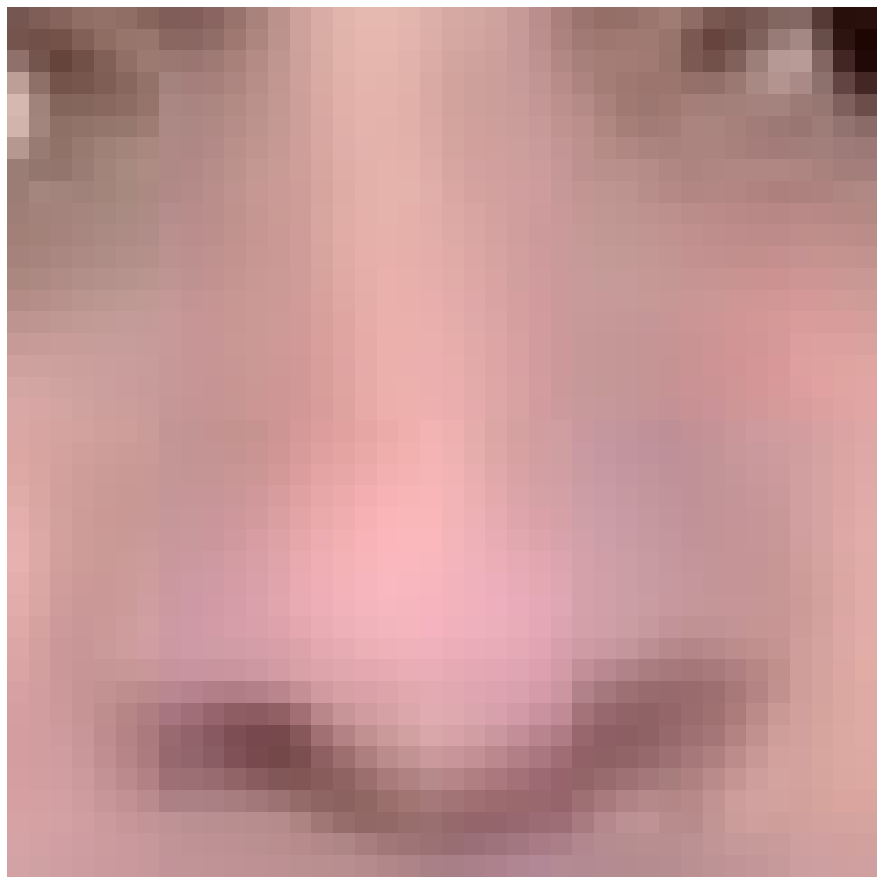

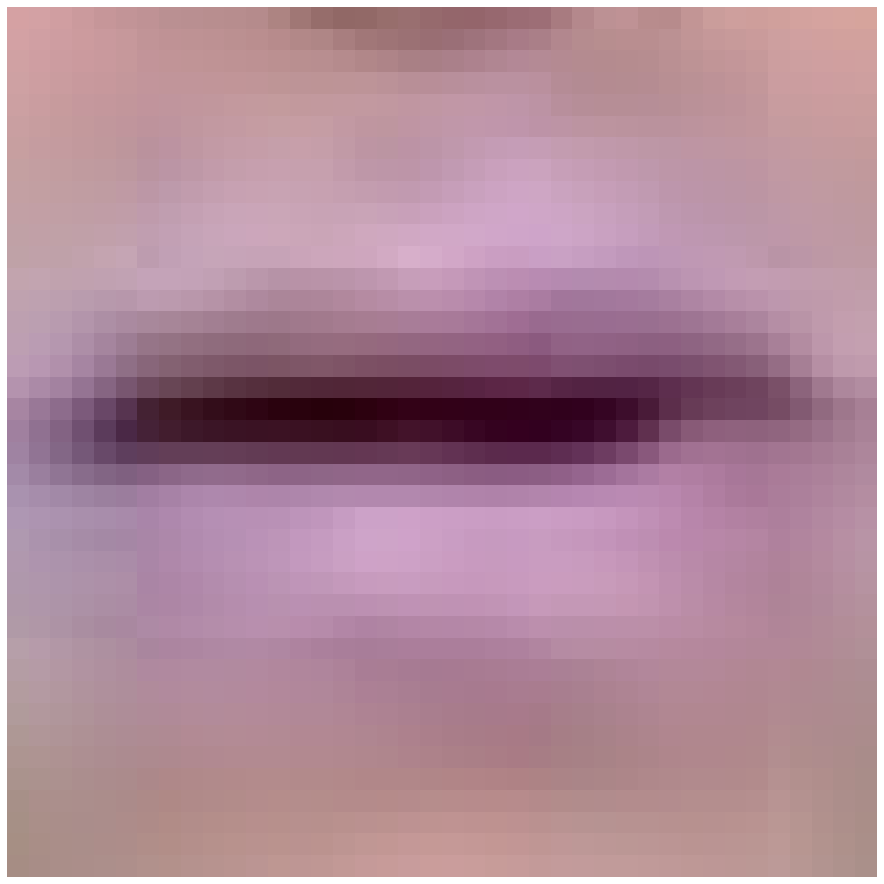

(19200,)


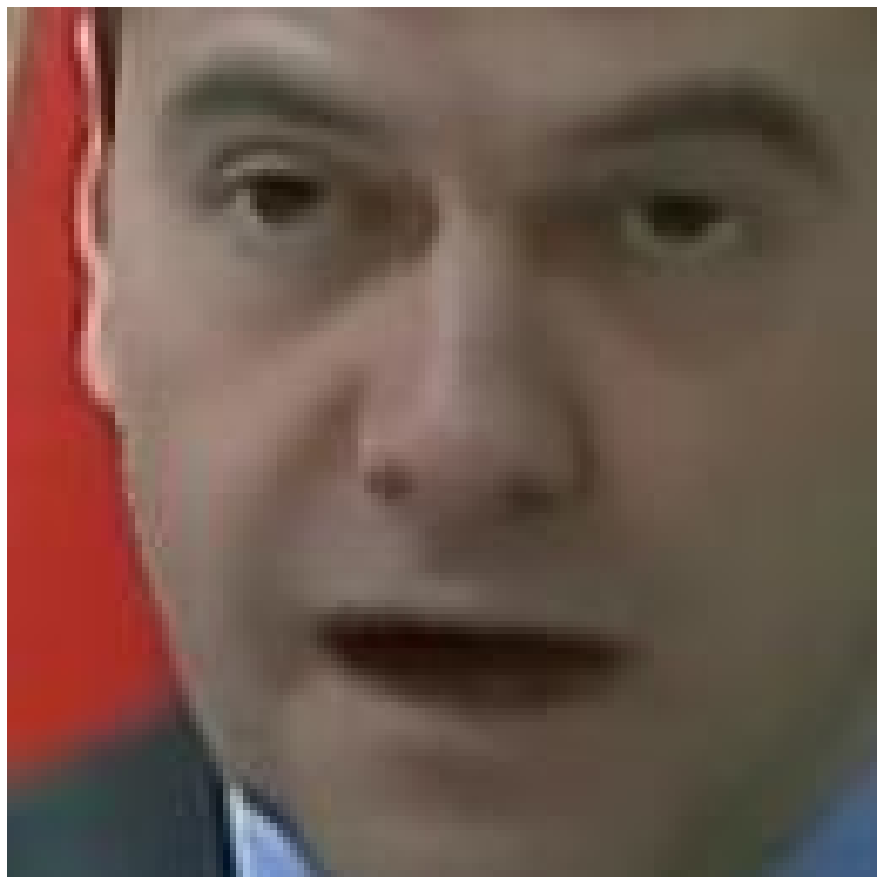

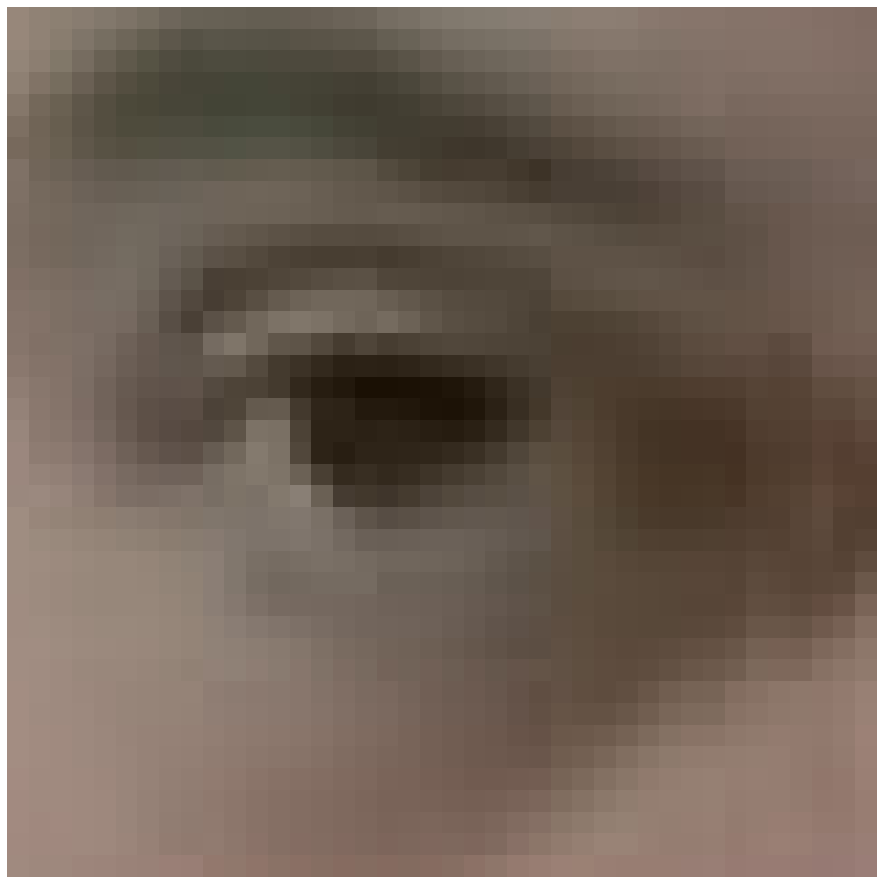

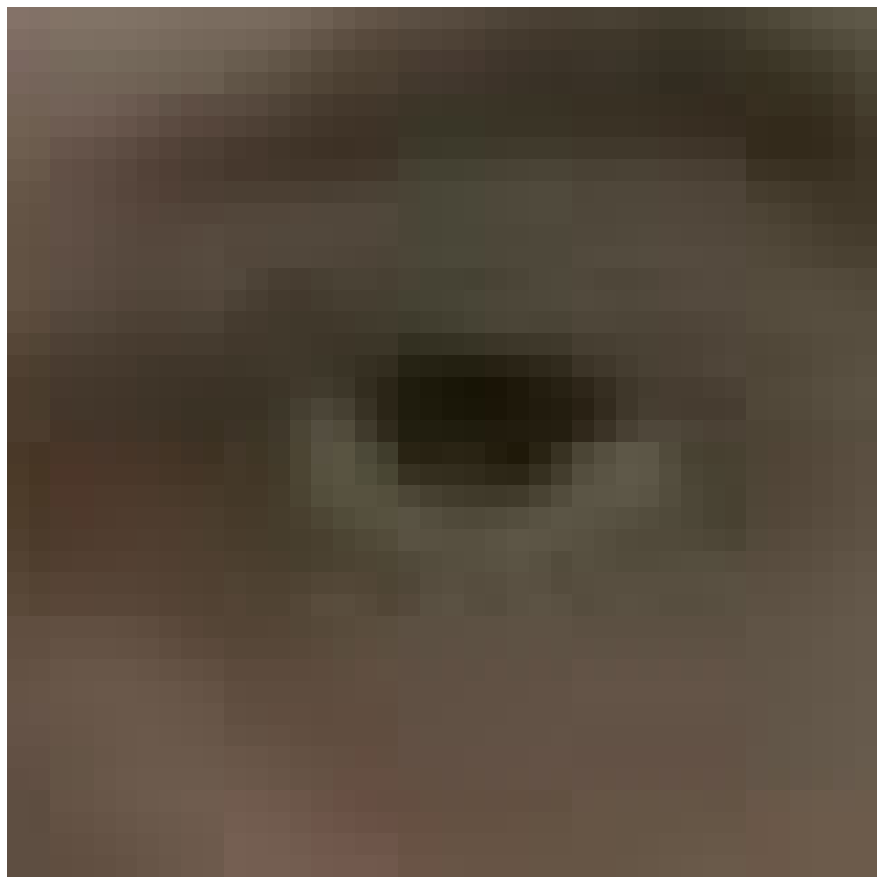

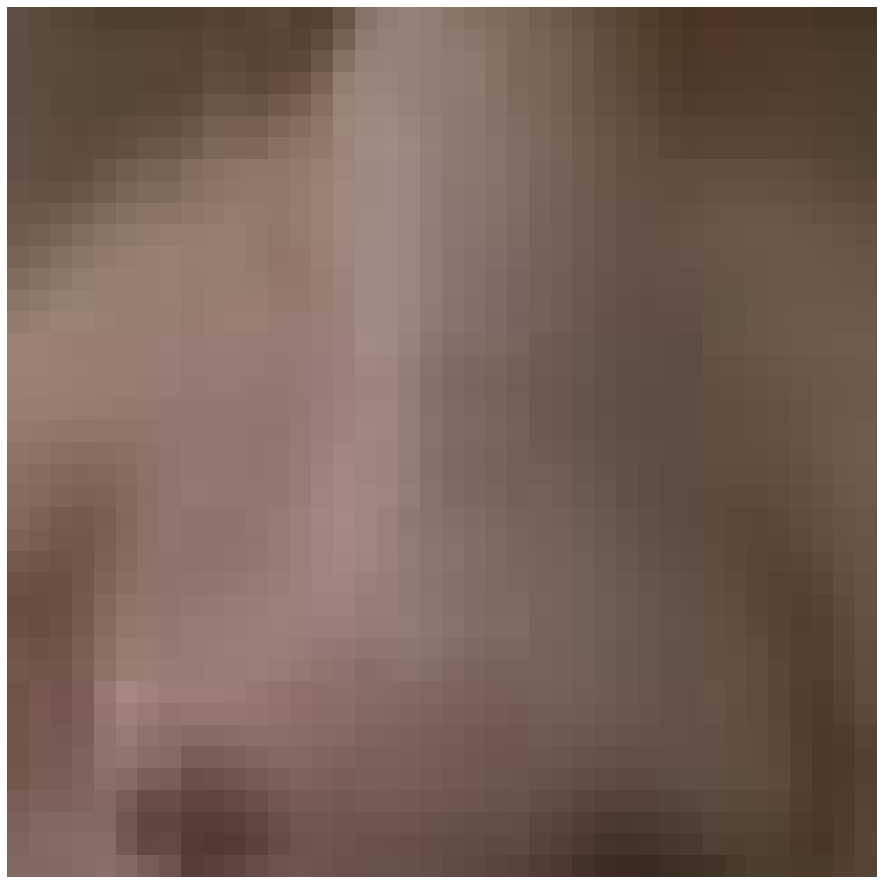

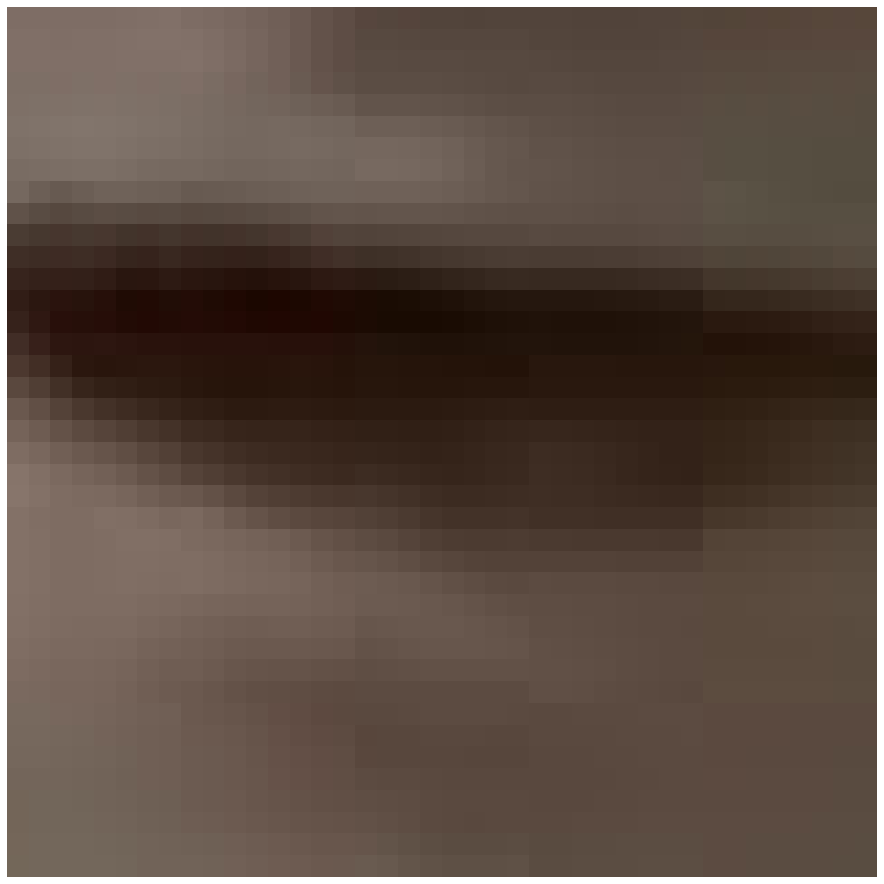

(19200,)


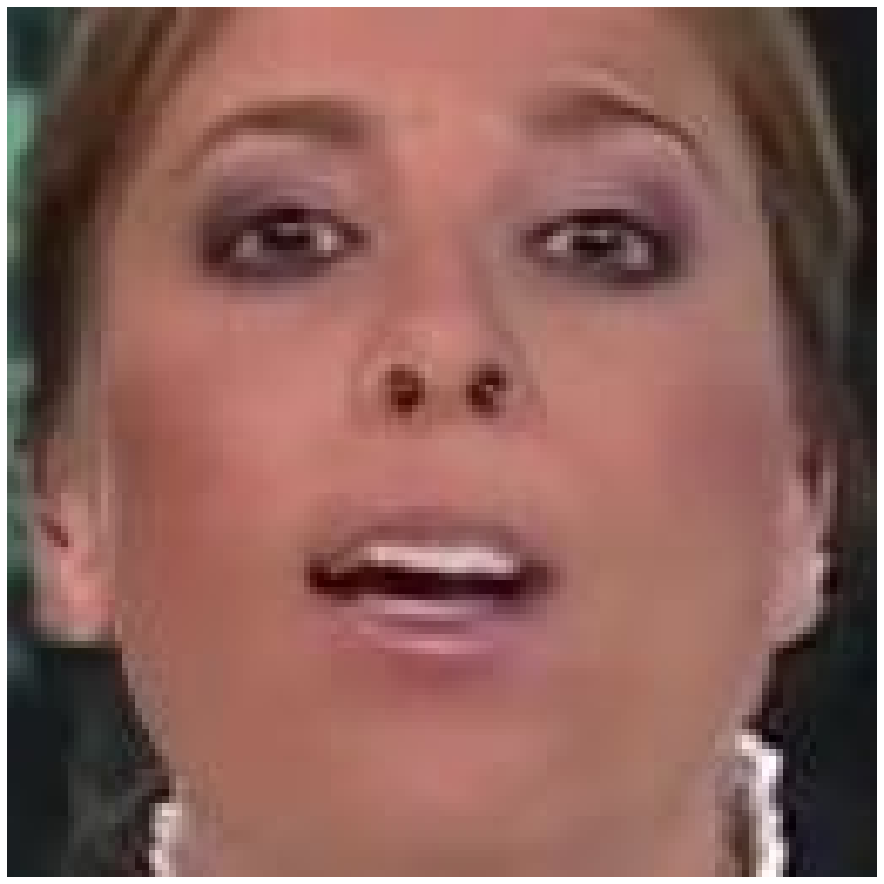

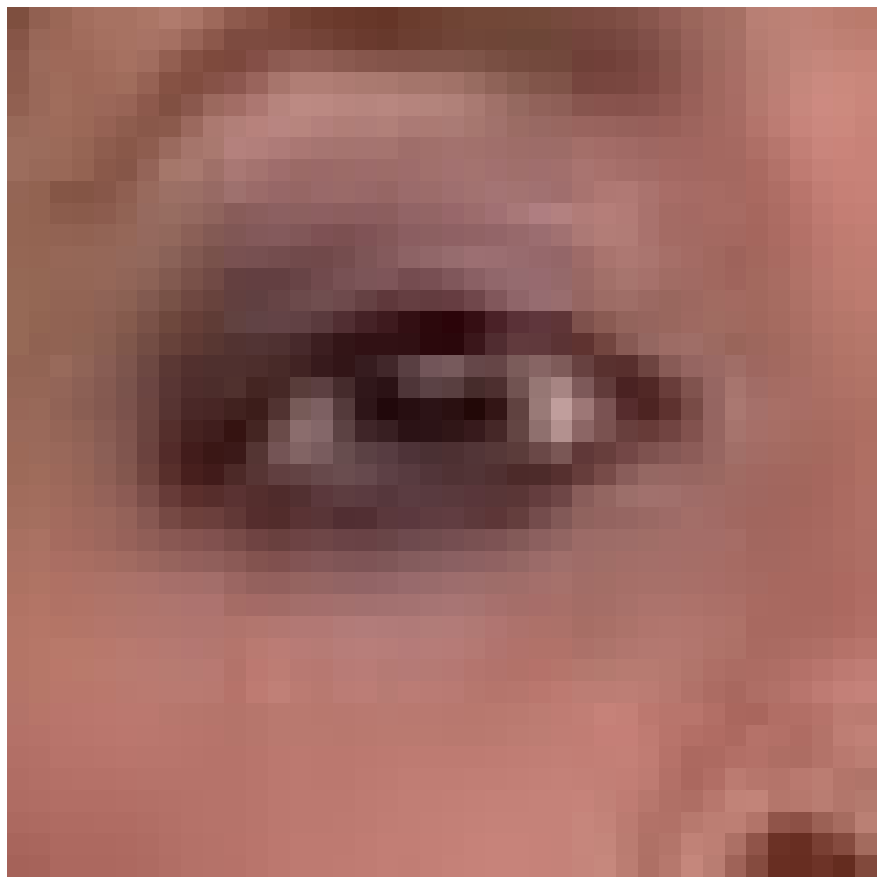

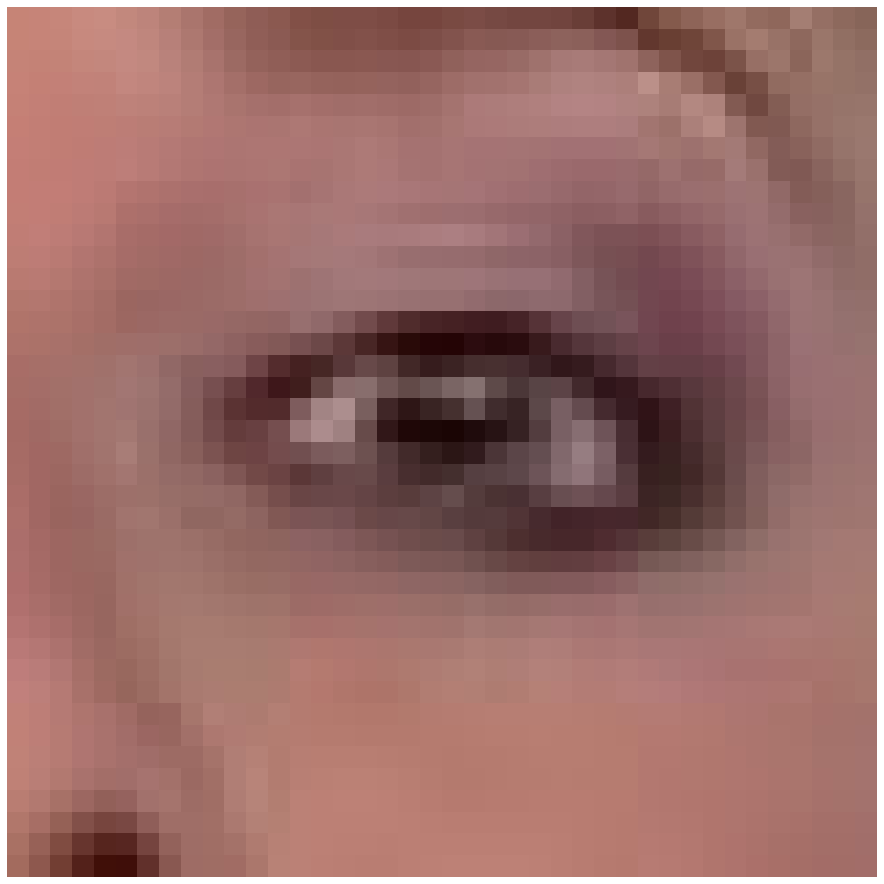

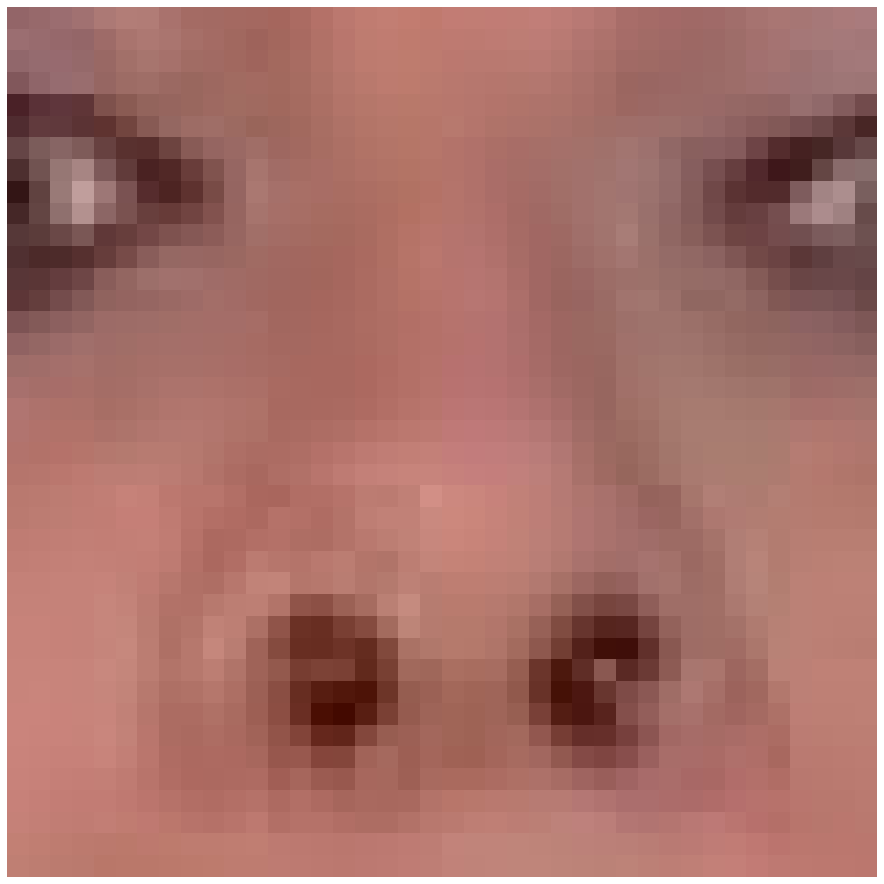

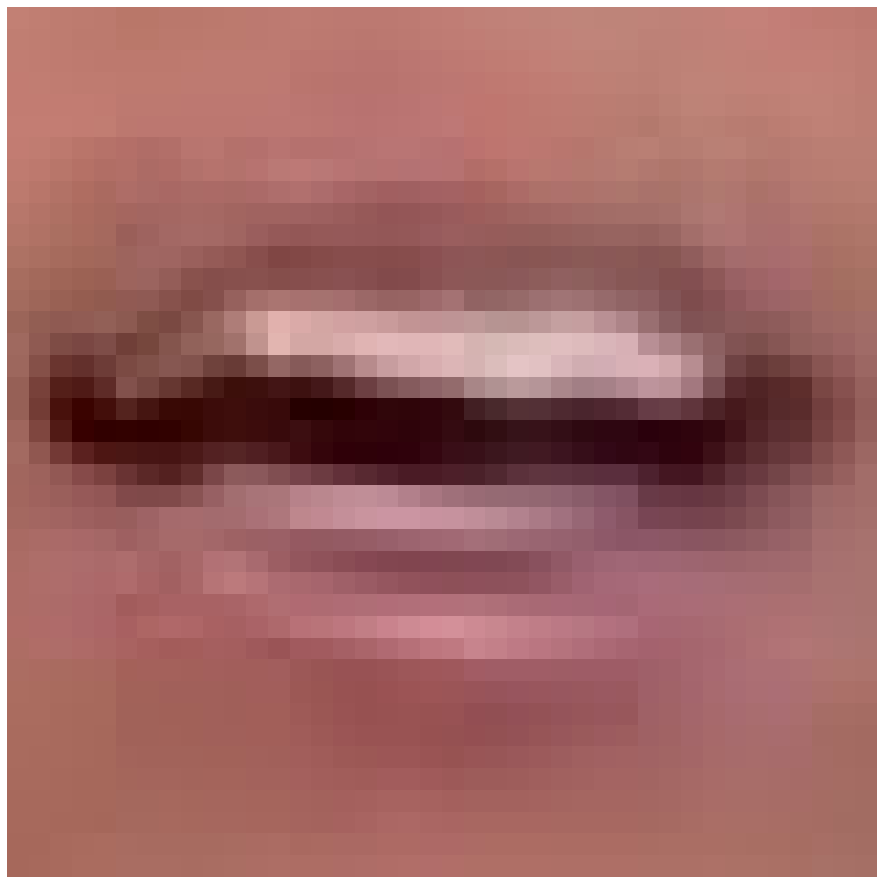

(19200,)


In [23]:
from PIL import Image

feature_vectors = []
for image in face2face_images:
  feature_vector = get_feature_vector(image)
  feature_vectors.append(feature_vector)
  print(feature_vector.shape)

TypeError: ignored

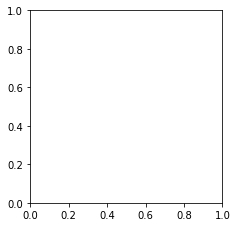

In [18]:
show_images(feature_vectors)